In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from src.utils import load_train_and_dev

In [3]:
data = pd.concat(load_train_and_dev('..'))

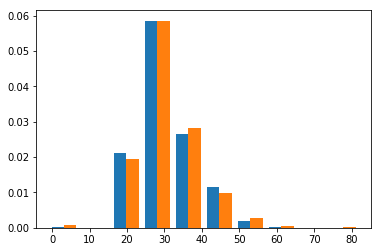

In [4]:
column = 'testlevel'
labels = data[column].unique()
vals = [data[data[column] == l].age for l in labels]
plt.hist(vals, density=True);

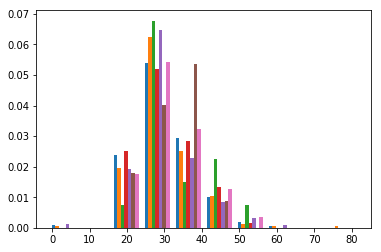

In [5]:
column = 'cefr'
labels = data[column].unique()
vals = [data[data[column] == l].age for l in labels]
plt.hist(vals, density=True);

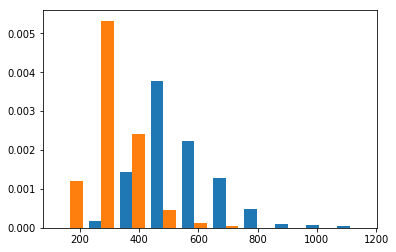

In [6]:
column = 'testlevel'
labels = data[column].unique()
vals = [data[data[column] == l].num_tokens for l in labels]
plt.hist(vals, density=True);

In [7]:
sorted(data.title.unique())

["'Import' av helsepersonell",
 'Adopsjon',
 'Alkohol og alkoholvaner',
 'Barn og fysiske aktiviteter',
 'Barndom og voksenverden',
 'Barneoppdragelse',
 'Bestselgere og bokbransjen',
 'Bilbruk',
 'Bilisme',
 'Boformer',
 'Bolig og bosted',
 'Bolig og boutgifter',
 'Bomiljø',
 'Borgerlønn',
 'Bruk av musikk',
 'Den gode skolen',
 'Den lille forskjellen',
 'Den norske naturen',
 'Det norske monarkiet',
 "Diktet 'Det er langt mellom venner' av Kolbjørn Falkeid",
 "Diktet 'Et møte' av Kolbein Falkeid",
 "Diktet 'Ingen ting' av Paulus Utsi om språk",
 "Diktet 'Mayday' av Lars Saabye Christensen",
 "Diktet 'Privat huskeregel' av Kolbjørn Falkeid",
 "Diktet 'Sannheten' av Rolf Jacobsen",
 "Diktet 'Synsvinkel' av Gunnar Øi",
 "Diktet 'Toleranse'",
 'Eldrebølgen',
 'En bok fra din kultur eller ditt hjemland',
 'En forfatter og om en bok han/ hun har skrevet',
 'En hyggelig opplevelse',
 'En interesse du har',
 'En kjent person',
 'En person som har betydd mye for deg',
 'Enpersons-husholdninge